In [1]:
import pandas as pd
import yfinance as yf
import datetime
from datetime import date, timedelta
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

data = yf.download('GOOG', 
                      start=start_date, 
                      end=end_date, 
                      progress=False)
data["Date"] = data.index
data = data[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
data.reset_index(drop=True, inplace=True)
print(data.tail())

          Date        Open        High         Low       Close   Adj Close  \
246 2024-08-12  165.994995  166.699997  163.550003  163.949997  163.949997   
247 2024-08-13  165.184998  166.539993  164.770004  165.929993  165.929993   
248 2024-08-14  164.210007  164.960007  159.529999  162.029999  162.029999   
249 2024-08-15  162.210007  163.520004  161.490005  163.169998  163.169998   
250 2024-08-16  163.410004  166.949997  163.080002  164.740005  164.740005   

       Volume  
246  12435000  
247  12717600  
248  22515900  
249  18392500  
250  16839100  


We only need the date and close prices columns for the rest of the task, so let’s select both the columns and move further:

In [3]:
data = data[["Date", "Close"]]
print(data.head())

        Date       Close
0 2023-08-18  128.110001
1 2023-08-21  128.929993
2 2023-08-22  129.690002
3 2023-08-23  133.210007
4 2023-08-24  130.419998


Now let’s visualize the close prices of Google before moving forward:

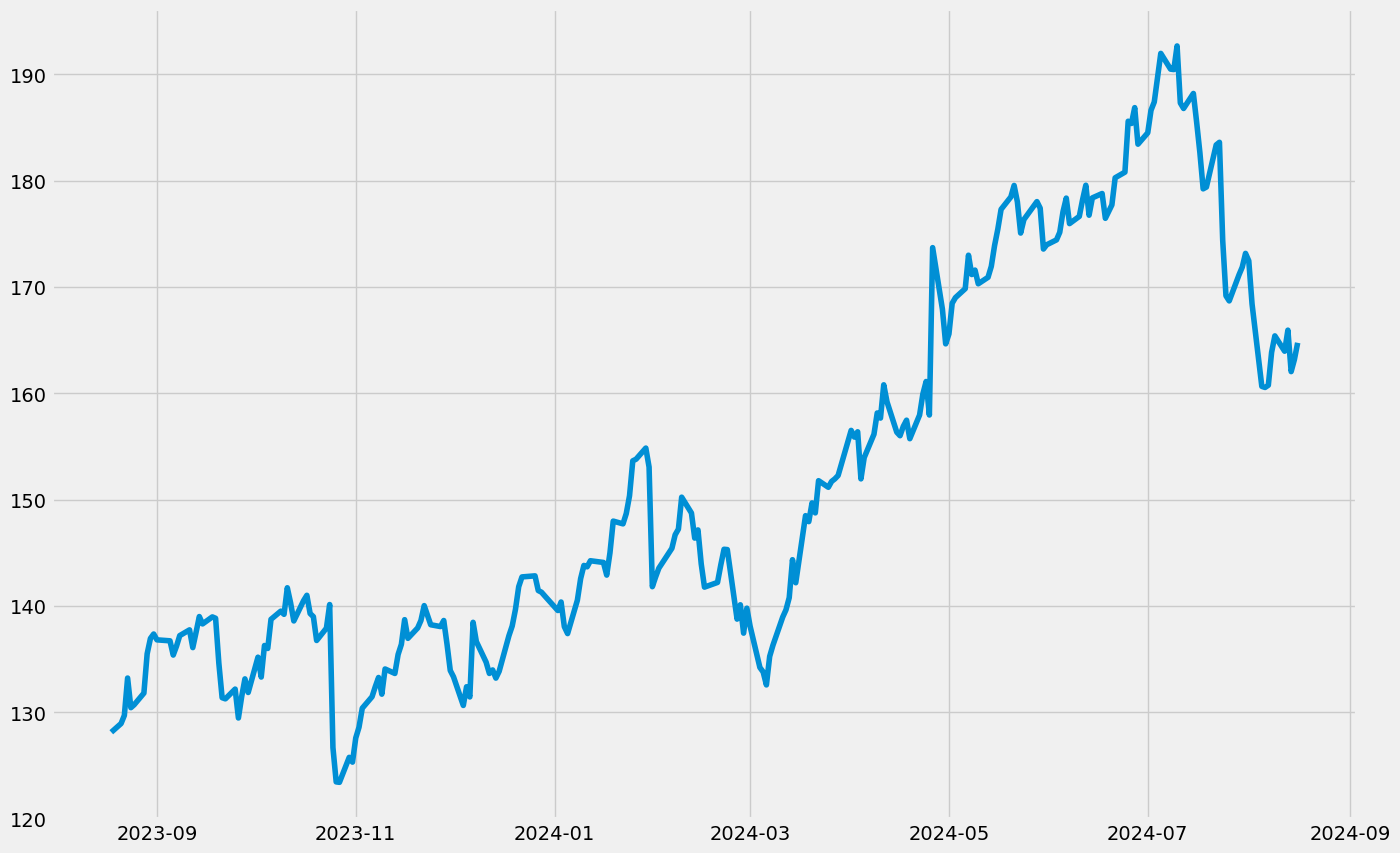

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 10))
plt.plot(data["Date"], data["Close"])

<Figure size 640x480 with 0 Axes>

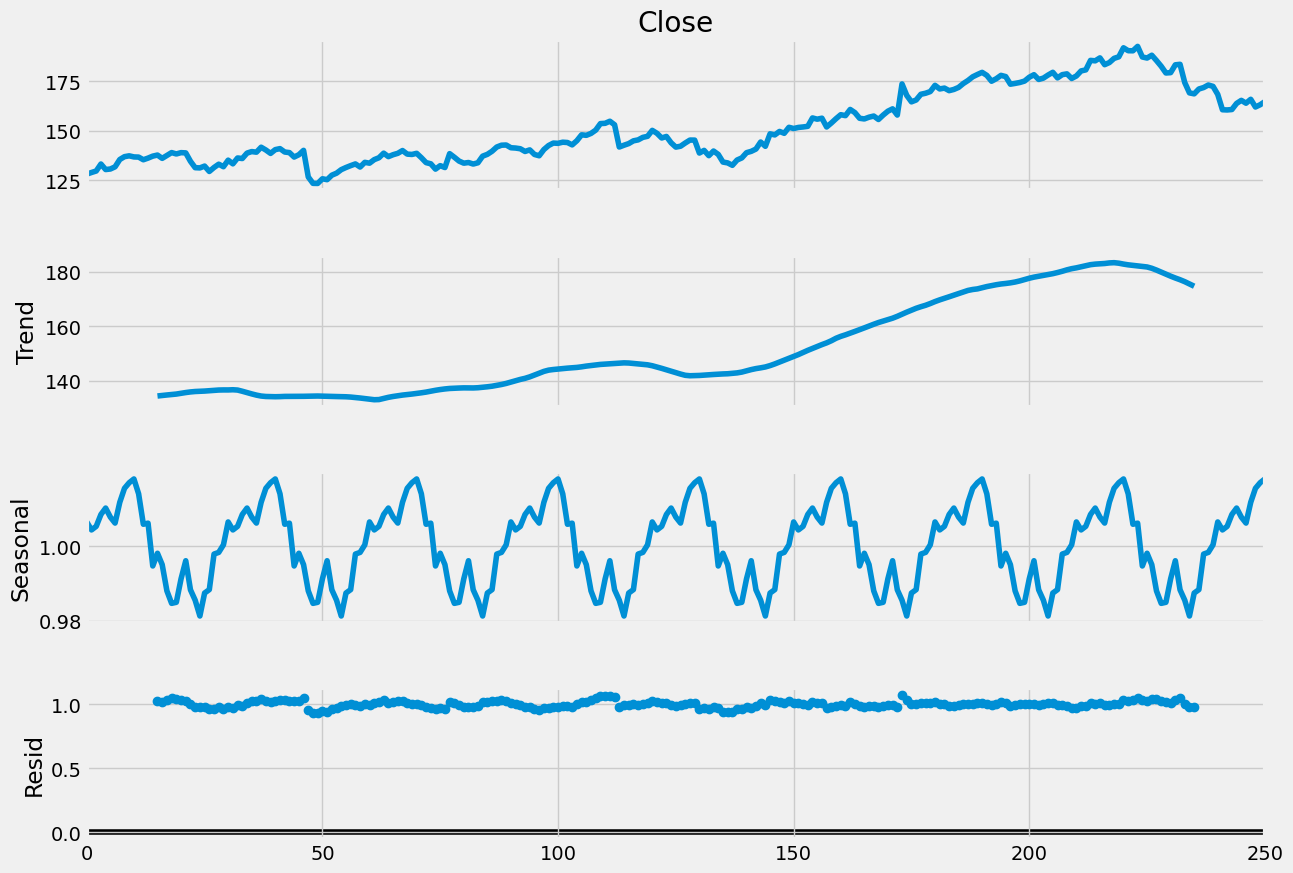

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data["Close"], 
                            model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 10)

So our data is not stationary it is seasonal. We need to use the Seasonal ARIMA (SARIMA) model for Time Series Forecasting on this data. But before using the SARIMA model, we will use the ARIMA model. It will help you learn using both models.

To use ARIMA or SARIMA, we need to find the p, d, and q values. We can find the value of p by plotting the autocorrelation of the Close column and the value of q by plotting the partial autocorrelation plot. The value of d is either 0 or 1. If the data is stationary, we should use 0, and if the data is seasonal, we should use 1. As our data is seasonal, we should use 1 as the d value.

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

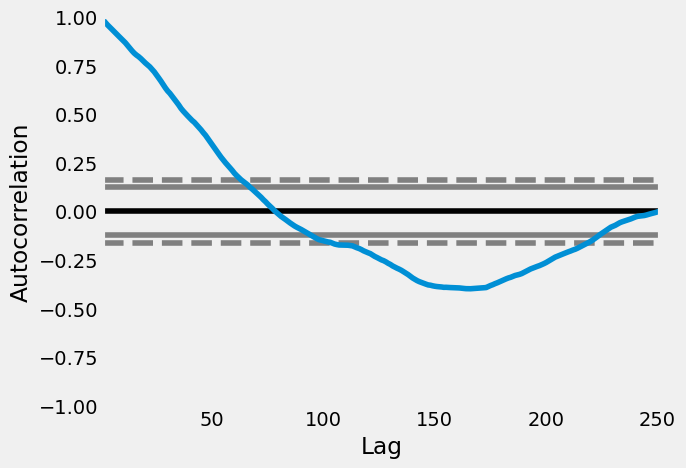

In [15]:
pd.plotting.autocorrelation_plot(data["Close"])

In the above autocorrelation plot, the curve is moving down after the 5th line of the first boundary. That is how to decide the p-value. Hence the value of p is 5. Now let’s find the value of q (moving average):

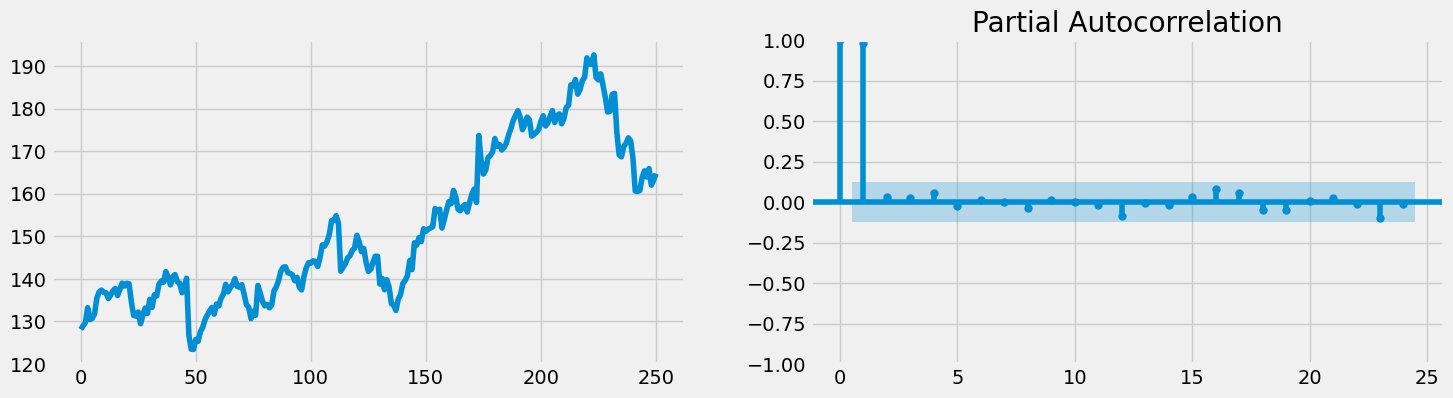

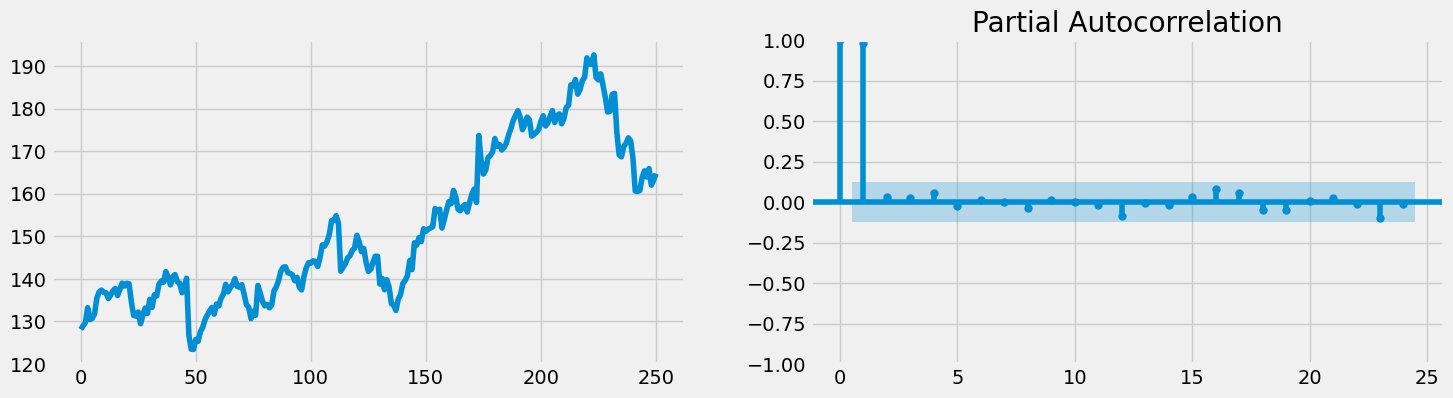

In [55]:
from statsmodels.graphics.tsaplots import plot_pacf
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(data['Close'])
plot_pacf(data["Close"],ax=ax2)

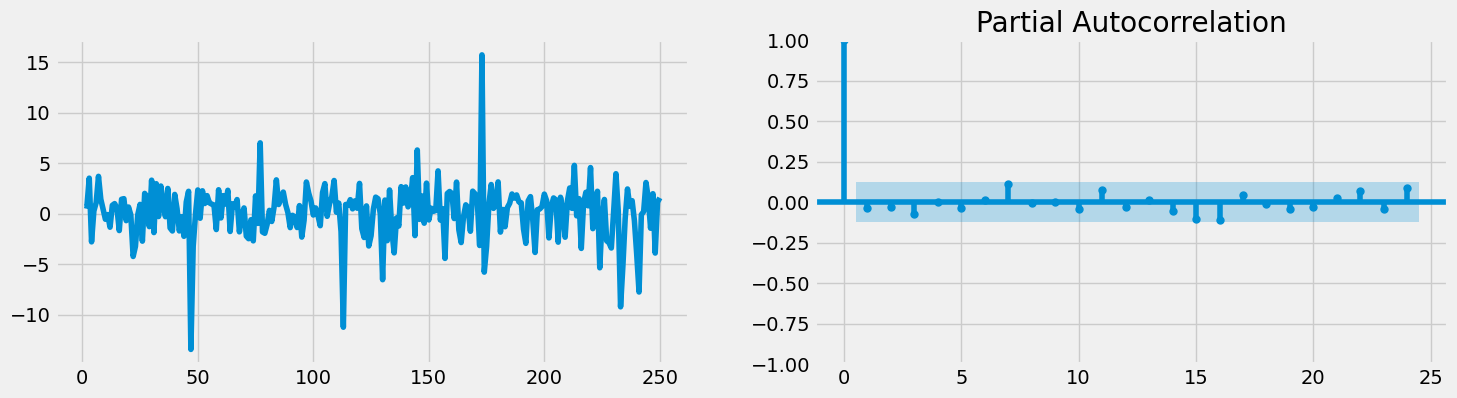

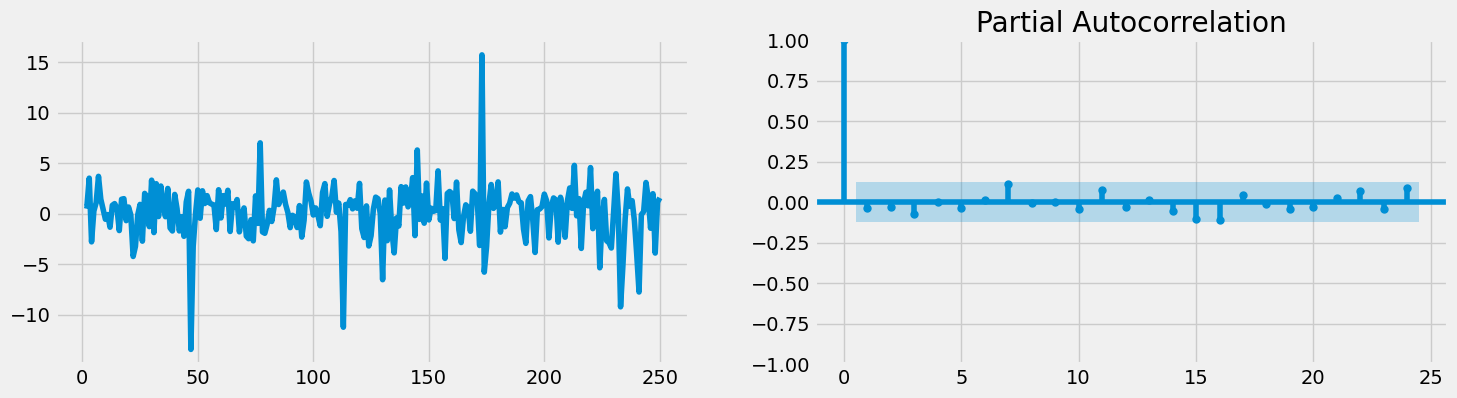

In [57]:
diff=data['Close'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(16,4))
ax1.plot(diff)
plot_pacf(diff,ax=ax2)

In [75]:
from pmdarima.arima.utils import ndiffs
ndiffs(data['Close'],test='adf')

1

In the above partial autocorrelation plot, we can see that only two points are far away from all the points. Hence the value of q is 2.
# ARIMA Model

In [77]:
p, d, q = 5, 1, 1
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data["Close"], order=(p,d,q))
# Fit the model
fitted = model.fit()
# Set the display option
fitted.params['disp'] = -1
# Print the summary
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(5, 1, 1)   Log Likelihood                -598.391
Date:                Sat, 17 Aug 2024   AIC                           1210.782
Time:                        23:28:27   BIC                           1235.432
Sample:                             0   HQIC                          1220.703
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1021      3.026     -0.034      0.973      -6.032       5.828
ar.L2         -0.0354      0.129     -0.276      0.783      -0.288       0.217
ar.L3         -0.0713      0.123     -0.581      0.5

In [80]:
predictions = fitted.predict()
print(predictions)

0        0.000000
1      128.109971
2      128.902792
3      129.640495
4      133.003438
          ...    
246    165.454312
247    163.724590
248    165.803576
249    162.110257
250    163.074913
Name: predicted_mean, Length: 251, dtype: float64


The predicted values are wrong because the data is seasonal. ARIMA model will never perform well on seasonal time series data. So, here’s how to build a SARIMA model:

In [83]:
import statsmodels.api as sm
import warnings
model=sm.tsa.statespace.SARIMAX(data['Close'],
                                order=(p, d, q),
                                seasonal_order=(p, d, q, 12))
model=model.fit()
print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Close   No. Observations:                  251
Model:             SARIMAX(5, 1, 1)x(5, 1, 1, 12)   Log Likelihood                -581.560
Date:                            Sat, 17 Aug 2024   AIC                           1189.121
Time:                                    23:29:08   BIC                           1234.260
Sample:                                         0   HQIC                          1207.313
                                            - 251                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2080      4.308     -0.048      0.961      -8.652       8.236
ar.L2         -0.0309      0.117   

Now let’s predict the future stock prices using the SARIMA model for the next 10 days:



In [85]:
predictions = model.predict(len(data), len(data)+30)
print(predictions)

251    164.401433
252    164.166243
253    164.167830
254    164.175290
255    165.399013
256    164.886789
257    165.260162
258    164.559707
259    164.112806
260    165.236134
261    165.871865
262    166.524698
263    166.223787
264    165.423172
265    165.329239
266    165.912282
267    165.971851
268    165.266611
269    168.023454
270    168.357215
271    168.406665
272    168.482627
273    168.992160
274    169.100449
275    168.873167
276    169.426874
277    171.132956
278    170.989711
279    171.604654
280    170.020521
281    171.474478
Name: predicted_mean, dtype: float64


Here’s how you can plot the predictions:



<Axes: >

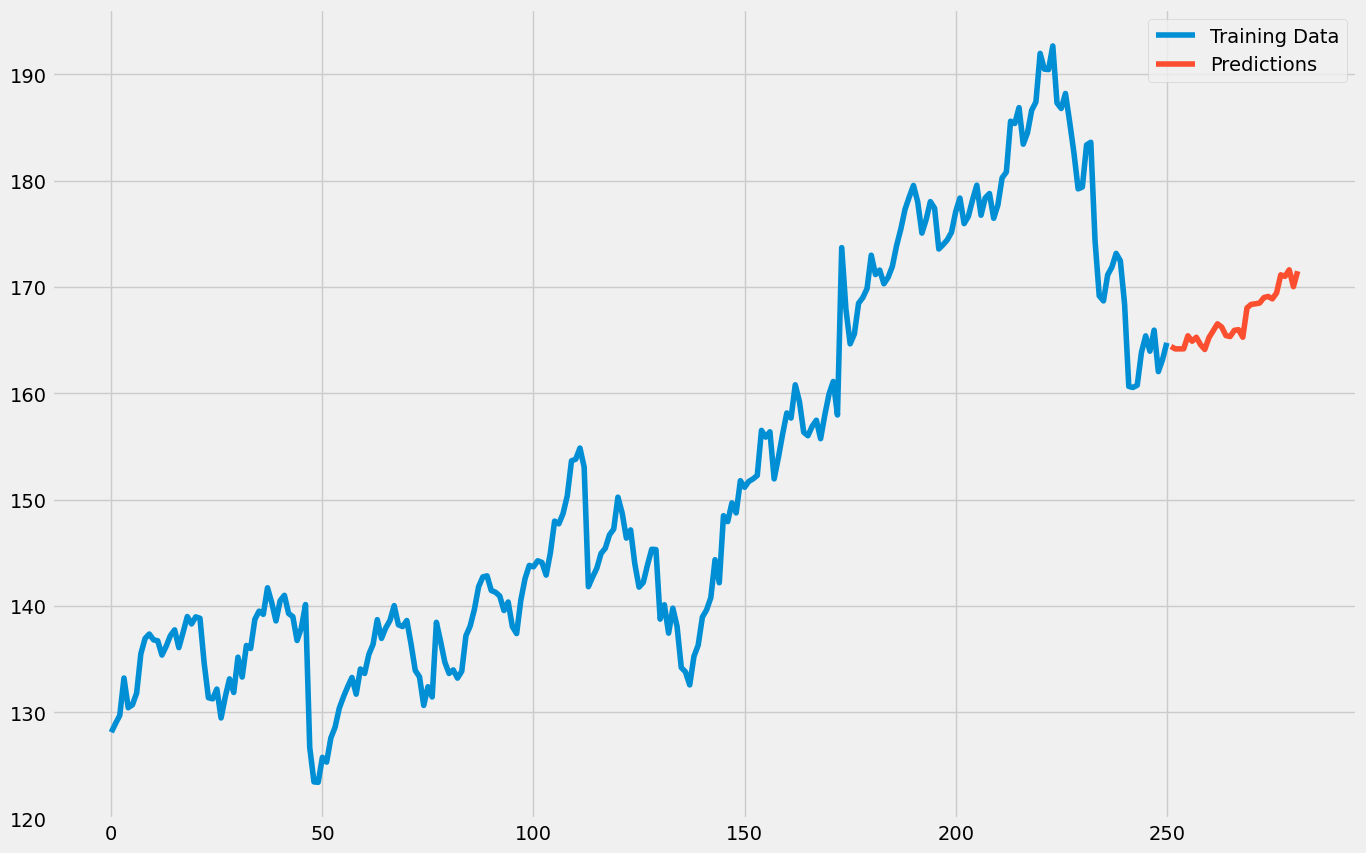

In [87]:
data["Close"].plot(legend=True, label="Training Data", figsize=(15, 10))
predictions.plot(legend=True, label="Predictions")